In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm
import pickle
import plotly.graph_objects as go
import plotly.io as pio
import chart_studio
import chart_studio.plotly as py

from open_ephys.analysis import Session
import pyopenephys as oe

from utils import plot_lfp, evoked_response_potential, butter_bandstop_filter, get_channel_idx, get_brain_region, find_stimuli

chart_studio.tools.set_config_file(world_readable=True, sharing='public')

### Data loading

In [2]:
#load data
DATA_FOLDER = "/data/jpatriota/R14/3.Probe test/2021-09-23_00-16-10"
EXP_FOLDER = "/data/jpatriota/R14/3.Probe test/2021-09-23_00-16-10/Record Node 107/"
session = Session(DATA_FOLDER)

info = session.recordnodes[0].recordings[0].info['continuous'][0]
Fs = info['sample_rate']
channels = info['channels']
channel_names = [c['channel_name'] for c in channels]
unique_channel_names = np.unique(channel_names)
unique_data_channel_names = np.unique(channel_names[0:127])
brain_regions = ["A1T", "BLAT", "HPCT", "PFCT"]

# dead_channels = {105, 106, 90, 91, 66, 67, 68, 69, 70, 36, 37, 38, 125, 126, 127, 122, 111, 97, 98, 101, 102, 84, 29, 30, 31}


# cannot load data via session (permission denied)
# samples = session.recordnodes[0].recordings[0].continuous[0].samples

data_file = oe.File(EXP_FOLDER)
experiments = data_file.experiments

experiment = experiments[0]
recordings = experiment.recordings

rec1 = recordings[0]
rec2 = recordings[1]

signal = rec1.analog_signals[0].signal
# ts = np.asarray(rec1.analog_signals[0].times)


Loading Open-Ephys: reading settings...
Decoding data from  binary  format
Reading oebin file
Reading oebin file


### Downsampling and filtering

In [3]:
fs_target = 1000
ds_factor = Fs // fs_target
ds_length = signal.shape[1] // ds_factor

downsampled_signal = np.empty((signal.shape[0], ds_length))
# downsampled_ts = np.empty(ds_length)

for idx in range(ds_length):
    downsampled_signal[:, idx] = signal[:, idx * ds_factor] 
    # downsampled_ts[idx] = ts[idx * ds_factor]


In [4]:
filtered_signal = butter_bandstop_filter(downsampled_signal[:128], lowcut=48, highcut=51, fs=fs_target, order=5)

### Save data

Can't do it, array too large and not enough memory

### Get stimuli occurences

In [5]:
CSmin_idx = find_stimuli(downsampled_signal[144], threshold=10000, fs=fs_target, min_spacing=119)
CSplus_idx = find_stimuli(downsampled_signal[145], threshold=10000, fs=fs_target, min_spacing=119)

print(CSmin_idx)
print(CSplus_idx)


[200716, 403782, 610861, 847935, 987007]
[1164084, 1372162, 1563234, 1779308, 1919390, 2071461, 2347533]


### Free up memory


In [6]:
del downsampled_signal
del session

### Plot ERPs

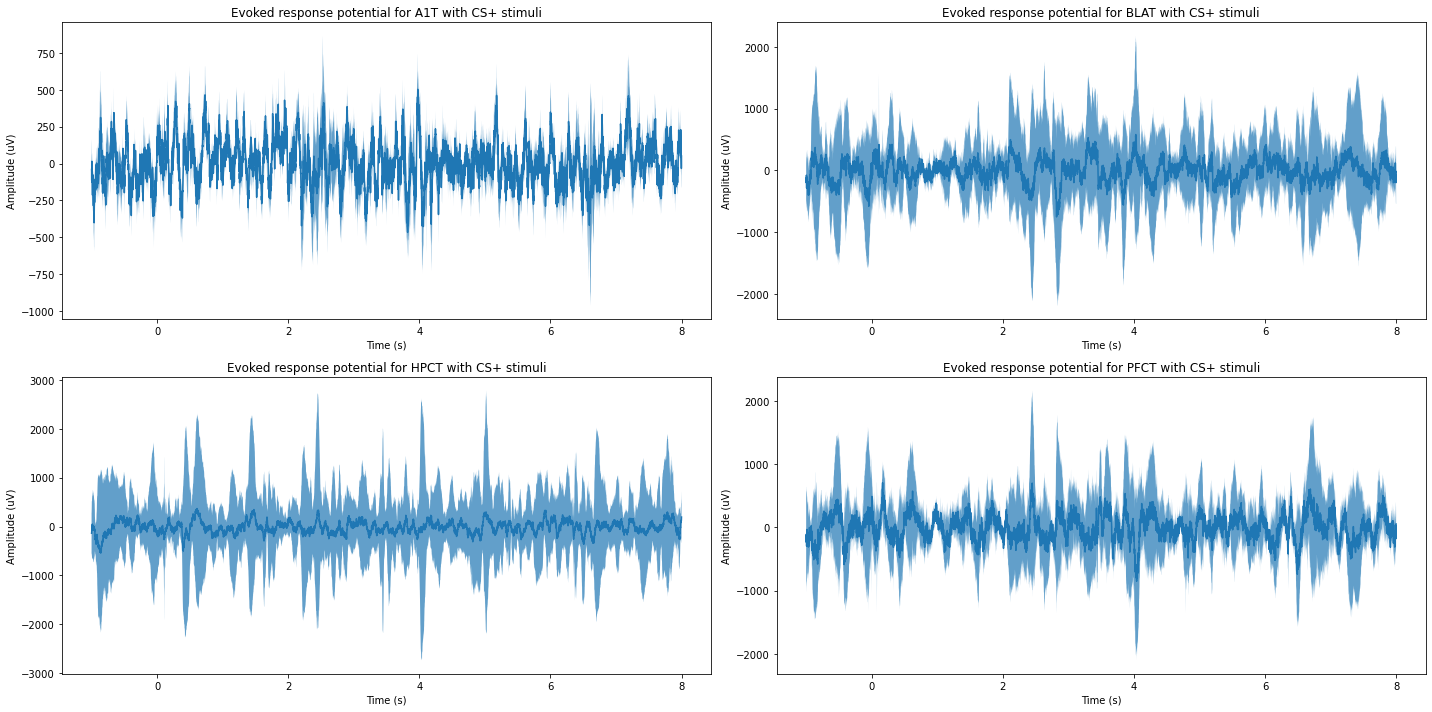

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for idx, br in enumerate(brain_regions):
    responses = []
    for trode in get_brain_region(unique_channel_names, br):
        channels = get_channel_idx(channel_names, trode)
        responses.append(evoked_response_potential(filtered_signal, CSplus_idx, channels, -1, 8, num_stimuli=0, plot=False))
    responses = np.vstack(responses)

    std = np.std(responses, axis=0)
    y_mean = np.mean(responses, axis=0)

    axes[idx].fill_between(np.linspace(-1, 8, responses.shape[1]), y_mean - std, y_mean + std, alpha=0.7)
    axes[idx].plot(np.linspace(-1, 8, responses.shape[1]), y_mean)                                                                                                                                                                                                                                            
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Amplitude (uV)")
    axes[idx].set_title(f"Evoked response potential for {br} with CS+ stimuli")

fig.tight_layout()
fig.show()

    
    
    

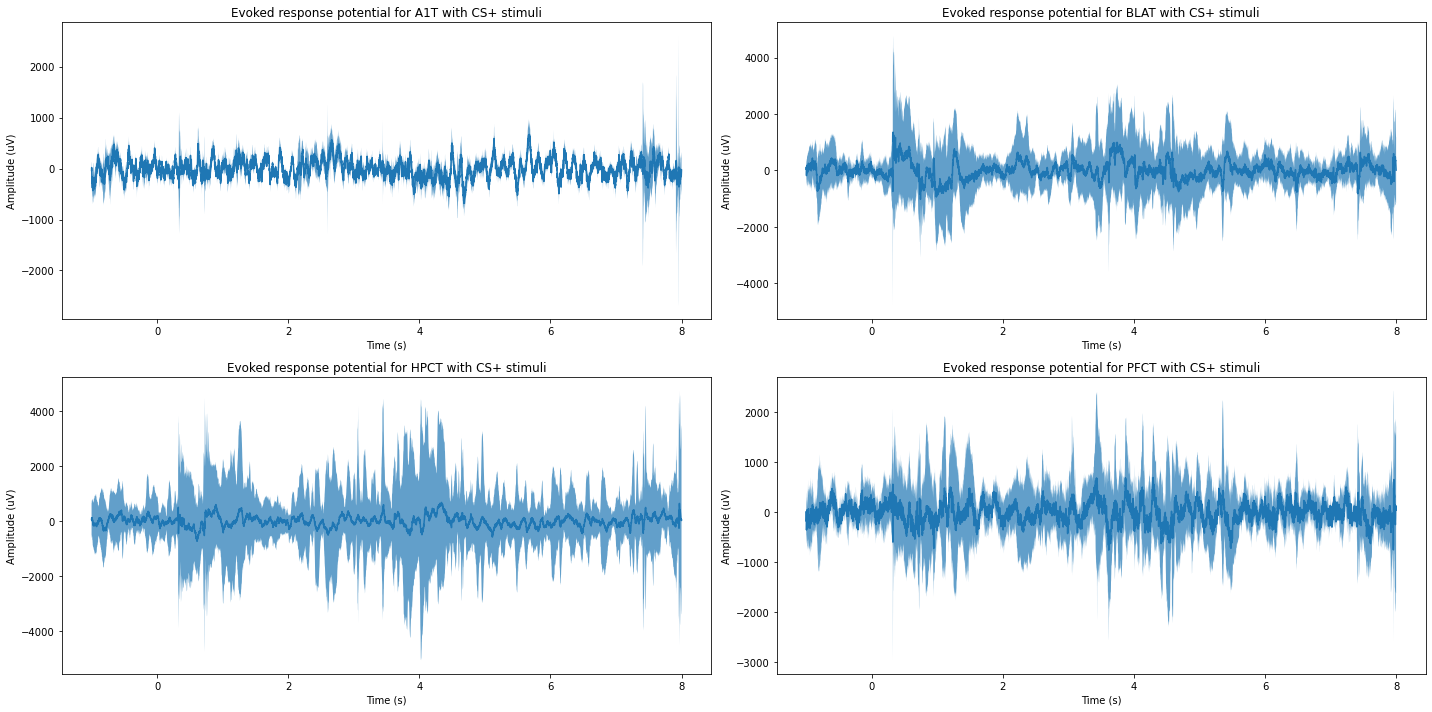

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

for idx, br in enumerate(brain_regions):
    responses = []
    for trode in get_brain_region(unique_channel_names, br):
        channels = get_channel_idx(channel_names, trode)
        responses.append(evoked_response_potential(filtered_signal, CSmin_idx, channels, -1, 8, num_stimuli=0, plot=False))
    responses = np.vstack(responses)

    std = np.std(responses, axis=0)
    y_mean = np.mean(responses, axis=0)

    axes[idx].fill_between(np.linspace(-1, 8, responses.shape[1]), y_mean - std, y_mean + std, alpha=0.7)
    axes[idx].plot(np.linspace(-1, 8, responses.shape[1]), y_mean)                                                                                                                                                                                                                                            
    axes[idx].set_xlabel("Time (s)")
    axes[idx].set_ylabel("Amplitude (uV)")
    axes[idx].set_title(f"Evoked response potential for {br} with CS+ stimuli")

fig.tight_layout()
fig.show()

In [9]:

br = brain_regions[0]
traces = []

for trode in get_brain_region(unique_channel_names, br):
    channels = get_channel_idx(channel_names, trode)
    response = evoked_response_potential(filtered_signal, CSmin_idx, channels, -1, 2, num_stimuli=0, plot=False)

    std = np.std(response, axis=0)
    t = np.linspace(-1, 2, response.shape[1])
    y_mean = np.mean(response, axis=0)

    for i, y in enumerate(response):
        traces.append(
            go.Scatter(
                name=channels[i],
                x=t,
                y=y,
                mode='lines',
            ))

    


In [12]:
menu = []
trodes = get_brain_region(unique_channel_names, br)
channels = []
for trode in trodes:
    channels.extend(get_channel_idx(channel_names, trode))



for idx, trode in enumerate(trodes):
    visible = [False] * len(channels)
    active_channels = get_channel_idx(channel_names, trode)
    for ch in active_channels:
        visible[channels.index(ch)] = True
    menu.append(dict(label=trode,
                    method="update",
                    args=[{"visible": visible},
                    {"title": f"Evoked response potential for {br} with CS- stimuli"}]))

layout = dict(
    updatemenus=list([dict(buttons=menu,)])
)


fig = go.Figure()
fig.add_traces(traces)
fig.update_layout(layout)
# fig.show(renderer='notebook')
fig.write_html("evoked_response_potential.html")